In [1]:

from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

from keras.layers import RepeatVector, Reshape, Concatenate, multiply

batch_size = 128*2  # orig paper trained all networks with batch_size=128
epochs = 120
data_augmentation = True
num_classes = 10

subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3
version = 2
depth = n * 9 + 2

model_type = 'ResNet%dv%d' % (depth, version)


import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

x_train = np.load('data/x_train.npy')
y_train = np.load('data/y_train.npy')
x_test = np.load('data/x_test.npy')
y_test = np.load('data/y_test.npy')

# print('x_train shape:', x_train.shape)
# print(x_train.shape[0], 'train samples')
# print(x_test.shape[0], 'test samples')

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

input_shape = x_train.shape[1:]

# if subtract_pixel_mean:
#     x_train_mean = np.mean(x_train, axis=0)
#     x_train -= x_train_mean
#     x_test -= x_train_mean

# print('x_train shape:', x_train.shape)
# print(x_train.shape[0], 'train samples')
# print(x_test.shape[0], 'test samples')
# print('y_train shape:', y_train.shape)

x_train.shape, y_train.shape, x_test.shape, y_test.shape


Using TensorFlow backend.


((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

In [2]:
model_type

'ResNet29v2'

In [3]:
epochs = 200


In [4]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
#     lr = 1e-3
#     if epoch > 180:
#         lr *= 0.5e-3
#     elif epoch > 160:
#         lr *= 1e-3
#     elif epoch > 120:
#         lr *= 1e-2
#     elif epoch > 80:
#         lr *= 1e-1
#     print('Learning rate: ', lr)
#     return lr

    lr = 1e-3
    if epoch > 160:
        lr *= 0.5e-3
    elif epoch > 140:
        lr *= 1e-3
    elif epoch > 100:
        lr *= 1e-2
    elif epoch > 60:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):

    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    new_block1 = x # ======================> add here
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    new_block2 = x
    # out-size = (None, 8, 8, 256)
    
    
    
    #################################
    # features

#     # inp = Input(shape=(7,7,1024))

#     feat1 = Conv2D(128, (1, 1), dilation_rate=2, padding='same')(inp)
#     feat11 = Conv2D(256, (3, 3), dilation_rate=2, padding='same')(feat1)

    #################################


    #################################
    # channel attention

    c_global_feat = keras.layers.AveragePooling2D(pool_size=(8,8))(new_block2)
    c_global_feat = Conv2D(256, (1, 1), 
                           padding='same',
                           kernel_initializer='he_normal',
                           kernel_regularizer=l2(1e-4))(c_global_feat)
#     c_global_feat = BatchNormalization()(c_global_feat)
    c_global_feat = Activation('relu')(c_global_feat)
    
    c_global_feat = Conv2D(256, (1, 1), 
                           padding='same',
                           kernel_initializer='he_normal',
                           kernel_regularizer=l2(1e-4))(c_global_feat)
    c_global_feat = Activation('sigmoid')(c_global_feat)

    channel_weighted_feat = keras.layers.Multiply()([new_block2, c_global_feat])
    channel_weighted_feat = Conv2D(256, (1, 1), padding='same')(channel_weighted_feat)
    # new_feat = keras.layers.Add()([feat11, weighted_feat])

    #################################


    #################################
    # spatial attention

    s_global_feat = Conv2D(256, (1, 1), 
                           padding='same',
                           kernel_initializer='he_normal',
                           kernel_regularizer=l2(1e-4))(new_block2)
    s_global_feat = Activation('relu')(s_global_feat)
    
    s_global_feat = Conv2D(1, (1, 1), 
                           padding='same',
                           kernel_initializer='he_normal',
                           kernel_regularizer=l2(1e-4))(s_global_feat)
    s_global_feat = Activation('sigmoid')(s_global_feat)

    # keras.layers.Multiply()([feat11, Dense(1)(feat11)])

    spatial_weighted_feat = keras.layers.Multiply()([new_block2, s_global_feat])
    spatial_weighted_feat = Conv2D(256, (1, 1), padding='same')(spatial_weighted_feat)

    #################################


    #################################
    # concat both attention features

    concat_s_c_feat = keras.layers.Concatenate(axis=-1)([channel_weighted_feat, spatial_weighted_feat])
    concat_s_c_feat = Conv2D(256, (1, 1), 
                             padding='same',
                             kernel_initializer='he_normal',
                             kernel_regularizer=l2(1e-4))(concat_s_c_feat)

    final_feat = keras.layers.Add()([new_block1, concat_s_c_feat])

    #################################
    # parallel_attention = Model(inp, final_feat)
    # parallel_attention.summary()
    
    x = final_feat
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
#     x = Conv2D(256, (1, 1), 
#                padding='same',
#                kernel_initializer='he_normal',
#                kernel_regularizer=l2(1e-4))(x)
    
    
    
    
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


# model = resnet_v2(input_shape=input_shape, depth=depth)

# model.compile(loss='categorical_crossentropy',
#               optimizer=Adam(lr=lr_schedule(0)),
#               metrics=['accuracy'])
# model.summary()
# # print(model_type)


In [ ]:
#################################
# features

inp = Input(shape=(7,7,1024))

feat1 = Conv2D(128, (1, 1), dilation_rate=2, padding='same')(inp)
feat11 = Conv2D(256, (3, 3), dilation_rate=2, padding='same')(feat1)

#################################


#################################
# channel attention

global_feat = keras.layers.AveragePooling2D(pool_size=(7,7))(feat11)
global_feat = Conv2D(256, (1, 1), padding='same')(global_feat)
global_feat = Activation('relu')(global_feat)
global_feat = Conv2D(256, (1, 1), padding='same')(global_feat)
global_feat = Activation('sigmoid')(global_feat)

channel_weighted_feat = keras.layers.Multiply()([feat11, global_feat])
channel_weighted_feat = Conv2D(256, (1, 1), padding='same')(channel_weighted_feat)
# new_feat = keras.layers.Add()([feat11, weighted_feat])

#################################


#################################
# spatial attention

global_feat = Conv2D(256, (1, 1), padding='same')(feat11)
global_feat = Activation('relu')(global_feat)
global_feat = Conv2D(1, (1, 1), padding='same')(global_feat)
global_feat = Activation('sigmoid')(global_feat)

# keras.layers.Multiply()([feat11, Dense(1)(feat11)])

spatial_weighted_feat = keras.layers.Multiply()([feat11, global_feat])
spatial_weighted_feat = Conv2D(256, (1, 1), padding='same')(spatial_weighted_feat)

#################################


#################################
# concat both attention features

concat_s_c_feat = keras.layers.Concatenate(axis=-1)([channel_weighted_feat, spatial_weighted_feat])
concat_s_c_feat = Conv2D(256, (1, 1), padding='same')(concat_s_c_feat)

final_feat = keras.layers.Add()([feat11, concat_s_c_feat])

#################################
parallel_attention = Model(inp, final_feat)
parallel_attention.summary()

In [5]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_attention_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    # epsilon for ZCA whitening
    zca_epsilon=1e-06,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    horizontal_flip=True,
    validation_split=0.0)

# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_test, y_test),
                    epochs=epochs, verbose=1, workers=4,
                    steps_per_epoch=int(1500/4),
                    callbacks=callbacks)



Using real-time data augmentation.
Epoch 1/120
Learning rate:  0.001
375/375 [==============================] - 38s 102ms/step - loss: 2.0713 - acc: 0.4640 - val_loss: 2.2535 - val_acc: 0.4146

Epoch 00001: val_acc improved from -inf to 0.41460, saving model to /home/ankish1/ankish_save/conditional-feature/saved_models/cifar10_attention_ResNet29v2_model.001.h5
Epoch 2/120
Learning rate:  0.001
375/375 [==============================] - 27s 73ms/step - loss: 1.5470 - acc: 0.6065 - val_loss: 1.8045 - val_acc: 0.5279

Epoch 00002: val_acc improved from 0.41460 to 0.52790, saving model to /home/ankish1/ankish_save/conditional-feature/saved_models/cifar10_attention_ResNet29v2_model.002.h5
Epoch 3/120
Learning rate:  0.001
375/375 [==============================] - 27s 73ms/step - loss: 1.3327 - acc: 0.6647 - val_loss: 1.7424 - val_acc: 0.5769

Epoch 00003: val_acc improved from 0.52790 to 0.57690, saving model to /home/ankish1/ankish_save/conditional-feature/saved_models/cifar10_attention_R

KeyboardInterrupt: 

In [5]:
import tensorflow as tf
# from keras.applications import Xception
from keras.utils import multi_gpu_model
import numpy as np

# num_samples = 1000
# height = 224
# width = 224
# num_classes = 1000

# Instantiate the base model (or "template" model).
# We recommend doing this with under a CPU device scope,
# so that the model's weights are hosted on CPU memory.
# Otherwise they may end up hosted on a GPU, which would
# complicate weight sharing.
with tf.device('/cpu:0'):
    model = resnet_v2(input_shape=input_shape, depth=depth)



#     model = Xception(weights=None,
#                      input_shape=(height, width, 3),
#                      classes=num_classes)

# Replicates the model on 8 GPUs.
# This assumes that your machine has 8 available GPUs.
parallel_model = multi_gpu_model(model, gpus=2)
parallel_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])

    
# parallel_model.compile(loss='categorical_crossentropy',
#                        optimizer='rmsprop')

# # Generate dummy data.
# x = np.random.random((num_samples, height, width, 3))
# y = np.random.random((num_samples, num_classes))

# # This `fit` call will be distributed on 8 GPUs.
# # Since the batch size is 256, each GPU will process 32 samples.
# parallel_model.fit(x, y, epochs=20, batch_size=256)

# # Save model via the template model (which shares the same weights):
# model.save('my_model.h5')

Learning rate:  0.001


In [6]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_attention_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    # epsilon for ZCA whitening
    zca_epsilon=1e-06,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    horizontal_flip=True,
    validation_split=0.0)

# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)


Using real-time data augmentation.


In [8]:
# Fit the model on the batches generated by datagen.flow().
parallel_model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                            validation_data=(x_test, y_test),
                            epochs=epochs, verbose=1, workers=4,
                            steps_per_epoch=int(1500/4),
                            callbacks=callbacks)


Epoch 1/200
Learning rate:  0.001
375/375 [==============================] - 60s 159ms/step - loss: 1.8783 - acc: 0.5258 - val_loss: 2.7577 - val_acc: 0.3421

Epoch 00001: val_acc improved from -inf to 0.34210, saving model to /home/ankish1/ankish_save/conditional-feature/saved_models/cifar10_attention_ResNet29v2_model.001.h5
Epoch 2/200
Learning rate:  0.001
375/375 [==============================] - 44s 117ms/step - loss: 1.3518 - acc: 0.6694 - val_loss: 1.6372 - val_acc: 0.5952

Epoch 00002: val_acc improved from 0.34210 to 0.59520, saving model to /home/ankish1/ankish_save/conditional-feature/saved_models/cifar10_attention_ResNet29v2_model.002.h5
Epoch 3/200
Learning rate:  0.001
375/375 [==============================] - 42s 113ms/step - loss: 1.1257 - acc: 0.7368 - val_loss: 1.2883 - val_acc: 0.6783

Epoch 00003: val_acc improved from 0.59520 to 0.67830, saving model to /home/ankish1/ankish_save/conditional-feature/saved_models/cifar10_attention_ResNet29v2_model.003.h5
Epoch 4/20

375/375 [==============================] - 43s 114ms/step - loss: 0.2227 - acc: 0.9925 - val_loss: 0.4772 - val_acc: 0.9194

Epoch 00066: val_acc did not improve from 0.92290
Epoch 67/200
Learning rate:  0.0001
375/375 [==============================] - 42s 113ms/step - loss: 0.2169 - acc: 0.9934 - val_loss: 0.4727 - val_acc: 0.9214

Epoch 00067: val_acc did not improve from 0.92290
Epoch 68/200
Learning rate:  0.0001
375/375 [==============================] - 44s 117ms/step - loss: 0.2117 - acc: 0.9936 - val_loss: 0.4721 - val_acc: 0.9240

Epoch 00068: val_acc improved from 0.92290 to 0.92400, saving model to /home/ankish1/ankish_save/conditional-feature/saved_models/cifar10_attention_ResNet29v2_model.068.h5
Epoch 69/200
Learning rate:  0.0001
375/375 [==============================] - 42s 113ms/step - loss: 0.2048 - acc: 0.9950 - val_loss: 0.4869 - val_acc: 0.9178

Epoch 00069: val_acc did not improve from 0.92400
Epoch 70/200
Learning rate:  0.0001
375/375 [=========================

375/375 [==============================] - 44s 117ms/step - loss: 0.1005 - acc: 0.9995 - val_loss: 0.4586 - val_acc: 0.9257

Epoch 00140: val_acc did not improve from 0.92640
Epoch 141/200
Learning rate:  1e-05
375/375 [==============================] - 43s 114ms/step - loss: 0.1003 - acc: 0.9995 - val_loss: 0.4560 - val_acc: 0.9265

Epoch 00141: val_acc improved from 0.92640 to 0.92650, saving model to /home/ankish1/ankish_save/conditional-feature/saved_models/cifar10_attention_ResNet29v2_model.141.h5
Epoch 142/200
Learning rate:  1e-06
375/375 [==============================] - 43s 114ms/step - loss: 0.0999 - acc: 0.9995 - val_loss: 0.4572 - val_acc: 0.9257

Epoch 00142: val_acc did not improve from 0.92650
Epoch 143/200
Learning rate:  1e-06
375/375 [==============================] - 44s 117ms/step - loss: 0.0999 - acc: 0.9995 - val_loss: 0.4563 - val_acc: 0.9262

Epoch 00143: val_acc did not improve from 0.92650
Epoch 144/200
Learning rate:  1e-06
375/375 [=========================

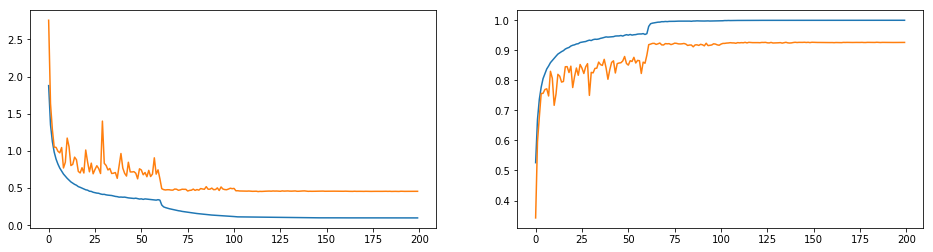

In [10]:
fig, ax = plt.subplots(1,2, figsize=(16,4))

ax[0].plot(range(200),parallel_model.history.history['loss'], range(200),parallel_model.history.history['val_loss'])
ax[1].plot(range(200),parallel_model.history.history['acc'], range(200),parallel_model.history.history['val_acc'])

In [12]:
# Score trained model.
scores = parallel_model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


10000/10000 [==============================] - 7s 665us/step
Test loss: 0.4563431936264038
Test accuracy: 0.926


In [4]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_attention_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    # epsilon for ZCA whitening
    zca_epsilon=1e-06,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    horizontal_flip=True,
    validation_split=0.0)

# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
resnet_model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_test, y_test),
                    epochs=epochs, verbose=1, workers=4,steps_per_epoch=int(1500/4),
                    callbacks=callbacks)



Using real-time data augmentation.


NameError: name 'resnet_model' is not defined

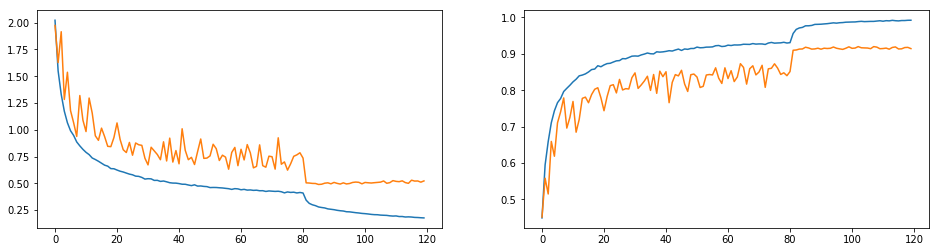

In [6]:
fig, ax = plt.subplots(1,2, figsize=(16,4))

ax[0].plot(range(120),model.history.history['loss'], range(120),model.history.history['val_loss'])
ax[1].plot(range(120),model.history.history['acc'], range(120),model.history.history['val_acc'])

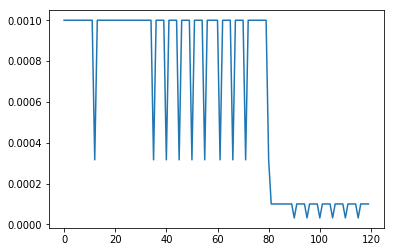

In [7]:
plt.plot(model.history.history['lr'])

In [8]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


10000/10000 [==============================] - 3s 267us/step
Test loss: 0.5226242788314819
Test accuracy: 0.9143
